# Deep Learning 2024 - Assignment 1

Designed by Marko Savic (marko.savic@oulu.fi)



## Outline (10 points)
#### Submission:
We will give 2 weeks for each assignment and more for the final project.

The grades will be released after the deadline. Please also put your name and student number (if you have one) in the file name of the returned assignments. (DL2024_assign1_NAME_SURNAME_STUDENTNUMBER.ipynb)

#### In this assignment, you will learn:
* How to load data and create a train/test split
* How to build your own Pytorch model for simple linear regression problem on the generated data.
* Training the model with gradient descent algorithm in Pytorch.
* Simple visualisation of data, loss and linear model

#### Tasks (10 points):
* Part 1. Load dataset and split into training and testing sets (1.5 points)
* Part 2.1 Model (1.5 points)
* Part 2.2 Training (7 points)

#### Environment
Python 3 + Pytorch (>=1.3).<br>
Other libraries should be installed correctly such as numpy, matplotlib, *etc*., according to the dependencies of the assignment. <br>
If you haven’t installed Pytorch and Jupyter notebook in your computer, an alternative environment to finish the assignment is CSC notebook: [`https://noppe.2.rahtiapp.fi/`](https://noppe.2.rahtiapp.fi/) -> log in with HaKa using your university account -> Jupyter Machine Learning.
Also, googlecolab is available through your google university account (instruction in https://www.oulu.fi/en/for-students/supporting-your-studies-and-contact-information-for-students/it-services-for-students/google-workspace-for-education). Computer room TS135 contains computers with GPUs that you can utilise as well.

We will give 2 weeks for each assignment and more for the final project. So it may happen where the new assignment is published before the deadline of the previous assignment. Please do not wait till the last minute to complete the assigments, as they can be time consuming.

#### Database
* Advertising dataset

#### Hints
* To find the place where you have to insert your solution, hit Crtl + F and search for **TODO:** . You are not supposed to modify the code from other parts.
* Be careful with the shape of the weights, gradient, .. of your tensor in your implementation. Double check and make sure the shapes fit for computation, especially matrix multiplication.
* Use only torch functions for the model, and avoid iterations. E.g. if you put a for cycle in the model function then parallelism is gone and your model will not run efficiently on GPUs. Also once you have the data loaded as tensors, you need to use torch functions, if you convert to numpy arrays in the training loop then it will not train efficiently.
* Check the examples from the pytorch tutorial lecture, they can help understand the assignment better.

## Part 1. Load dataset and split into training and testing sets

Suppose we observe a set of n real-valued input variables x = $\{x_n\}$ and wish to use this observation to predict
the value of a real-valued target variable $y$. In the tutorial we considered artifical examples with synthetic data. In this exercise we will consider a simple dataset that is suitable for linear regression.

We will take a small advertisement dataset. It contains data on the budget allocated for TV, radio and newspaper advertisements with the resulting sales. It contains n = 200 samples with three variables "TV", "Radio","Newspaper" and the value we want to predict, that is "Sales". Assuming a linear model is a good representation of the correlation between advertisement budgets and final sales, we will try to train a linear model to regress the sales based on advertisement budget.

The dataset is located in the advertisement .csv file and opened as a pandas Dataframe. Firstly we will turn the input variables and regression target into Tensors, and then split the data into training and testing sets. In this case we choose a five fold split, meaning we will use 20% of the data for testing (last 40 samples) and 80% for training (first 160 samples).

Please create the required training and testing data below and plot the relationship between the feature 'TV' and the target. Since we have 3 different features, we will only pick 'TV' a 2D plot.

In [128]:
!pip install onedrivedownloader

from onedrivedownloader import download
import os
link = 'https://unioulu-my.sharepoint.com/:x:/g/personal/msavic21_univ_yo_oulu_fi/Eb211jNyQAVIhTq1HsoxQyEBEqoDNHhr606Kfh9LY5Brjw?e=cONlaG'

#if not os.path.exists('./data/fashion_mnist_npy'):
#    print('Downloading dataset')
download(link, filename="./advertising.csv", unzip=True, unzip_path='./')

'./advertising.csv'

In [129]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import numpy as np
import pandas as pd

adv_dataset=pd.read_csv('./advertising.csv')
adv_dataset.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


torch.Size([200, 3]) torch.Size([200])
torch.Size([160, 3]) torch.Size([160])
torch.Size([40, 3]) torch.Size([40])


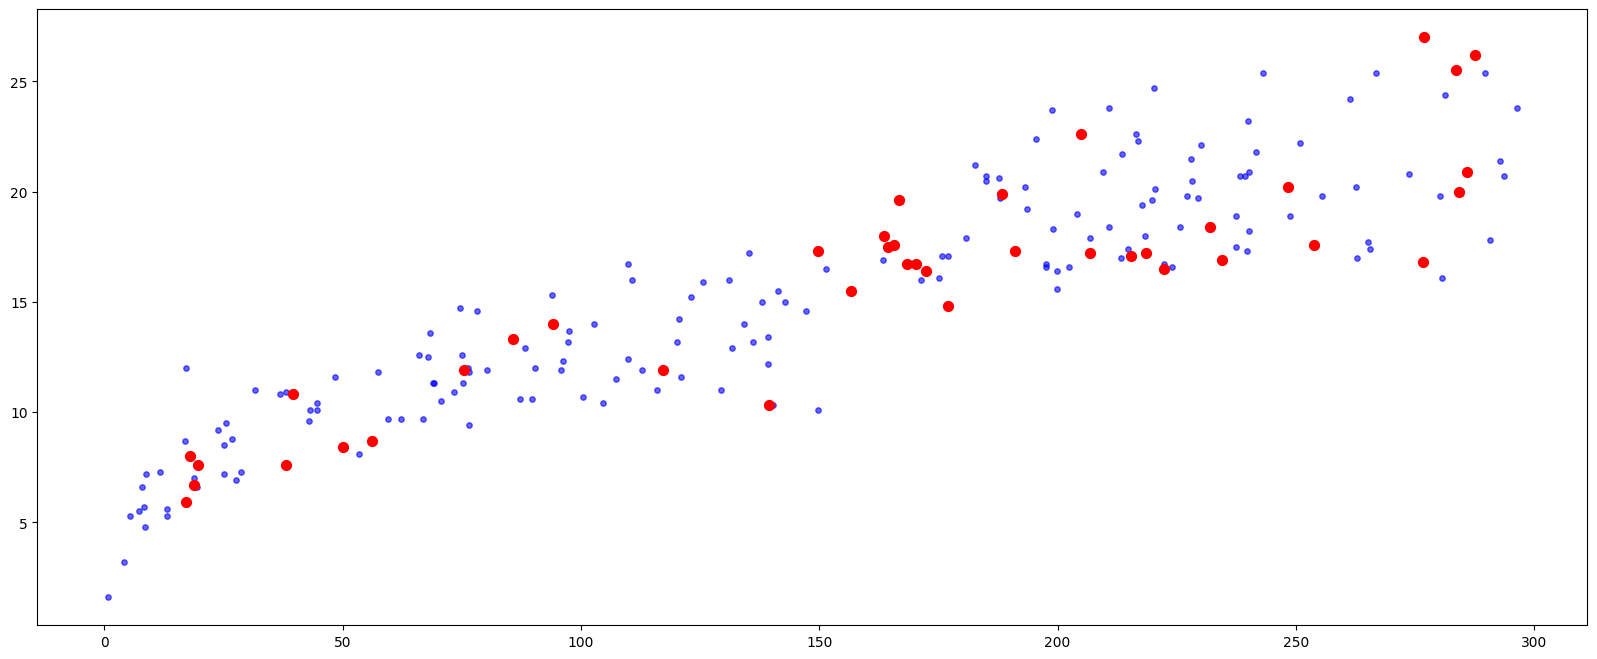

In [130]:
# TODO: (1.5 points, details are given below):

# get the relevant data from the adv_dataset dataframe and assign them to the Tensors x (feature variables) and y (target)  (0.5 point)
# YOUR CODE HERE

# Extract the relevant data into Tensors
x = torch.tensor(adv_dataset[['TV', 'Radio', 'Newspaper']].values, dtype=torch.float32)
y = torch.tensor(adv_dataset['Sales'].values, dtype=torch.float32)


print(x.size(),y.size())

# divide the data in a train set (80% of the data) and test set (20% of the data). Resulting in x_train, x_test, y_train, y_test (0.5 point)
# YOUR CODE HERE
n = len(x)
train_size = int(0.8 * n)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(x_train.size(),y_train.size())
print(x_test.size(),y_test.size())


# plot the first feature 'TV' in relationship with the target y. Train and test data should be in a single figure with two different colors (0.5 point)
# YOUR CODE HERE

plt.figure(figsize=(20, 8))
plt.scatter(x_train[:, 0], y_train, color='blue', label='Training Data',s=15,alpha = 0.6)
plt.scatter(x_test[:, 0], y_test, color='red', label='Testing Data',s=50)
plt.show()

## Part 2. Solving the linear regression problem in Pytorch using Gradient Descent Algorithm

Congratulations you have prepared the data correctly! Now we will move onto creating our model and training it.

### 2.1 Model
In this part, you will define your own model class. To do that, you have to remember the following rules:
1. The model class should be inherited from [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module);
2. Re-write the **\_\_init\_\_** function and the **forward** function;
3. In the **\_\_init\_\_** function, you should always call the parent's **\_\_init\_\_** function first.
4. Don't use the nn.Linear() layer, implement it yourself.
5. Use 1 tensor to define w (not 3) and 1 tensor to define b.
6. Only torch functions and no iterations inside the model.

To make it simpler, since we are using a linear function to approximate the phenomenon that generated the data, our function will be:

\begin{align*}
y = w^T x + b
\end{align*}

Therefore, in the model, we need to set 2 parameters: $w$, $b$

In [131]:
# TODO (1.5 points, details are given below)
import torch.nn as nn


# define a class (0.5) + write the __init__ function (0.5 point) + write the forward function (0.5 points)

# YOUR CODE HERE

class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.w = nn.Parameter(torch.randn(3))
        self.b = nn.Parameter(torch.randn(1))

    def forward(self, x):
        f = torch.sum(self.w*x, dim=1)+self.b
        #f = torch.matmul(x, self.w) + self.b
        return f

### 2.2 Training
Here, you will train your model based on the training data and evaluate the model on testing data.
1. Set proper number of iterations and learning rate.
2. Remember to use a proper optimizer (you may have many choices: Adam, SGD, RMSprop, ... please find the detailed information in https://pytorch.org/docs/stable/optim.html and know how to use them).
3. In order to train the model, a loss function should be defined:
\begin{align*}
loss = \frac{1}{N}\sum_{i=1}^{N}|f_i - y_i|,
\end{align*}
where, $f_i$ is the output of the model and $N$ is the number of training data pairs.
4. The model must be trained only using training data.
5. Remember to clear the old gradients of parameters before a new backward propagation.
6. In every certain number of iterations, print the values of the parameters, the training loss, and the testing loss.
7. Meanwhile, please track the training loss and the testing loss in each iteration. Once the training is done, the curves of losses should be plotted (two curves are drawn in the same figure, where x axis indicates iterations and y axis indicates the losses).
8. Lastly, draw all the training data, testing data and the curve of the trained model in the same figure (use different showing styles to distinguish them).

In [269]:
# TODO (7 points, details are given below)

# Make a instance of the model class (0.5 point)
# YOUR CODE HERE
model = LinearModel()

# create an optimizer, set a workable learing rate (1 point)
# YOUR CODE HERE

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Stochastic Gradient Descent optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

training_losses = []
testing_losses = []

n_itr = 10000

for i in range(n_itr):

    # Train
    # forward propagation
    model.train() # change model to train mode

    # calculate the output of model (0.5 point)
    # YOUR CODE HERE
    output = model(x_train)


    # calculate loss according to the above equation (1 point)
    # YOUR CODE HERE
    e = torch.abs(output - y_train)
    loss = e.mean()

    training_losses.append(loss.item())


    # backward propagation (clear old gradients, calculate gradients of parameters, gradient descent algorithm ) (1.5 point)
    # YOUR CODE HERE

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Evaluate, calculate the testing loss (1 point)
    model.eval() # change model to eval mode

    # YOUR CODE HERE
    eval_output = model(x_test)
    te = torch.abs(eval_output - y_test)
    test_loss = te.mean()

    testing_losses.append(test_loss.item())

    # print intermediate losses for certain iterations (0.5 point)
    if i % 100 == 1:
        print('Iteration: %04d | Training loss: %f | Testing loss: %f' % \
              (i, loss.data, test_loss.data))



Iteration: 0001 | Training loss: 76.319244 | Testing loss: 90.442978
Iteration: 0101 | Training loss: 59.005322 | Testing loss: 71.326584
Iteration: 0201 | Training loss: 43.879780 | Testing loss: 53.404327
Iteration: 0301 | Training loss: 31.406109 | Testing loss: 37.384724
Iteration: 0401 | Training loss: 22.657314 | Testing loss: 24.393200
Iteration: 0501 | Training loss: 18.145233 | Testing loss: 16.638924
Iteration: 0601 | Training loss: 15.015806 | Testing loss: 13.715006
Iteration: 0701 | Training loss: 11.945383 | Testing loss: 10.950732
Iteration: 0801 | Training loss: 8.844601 | Testing loss: 8.259127
Iteration: 0901 | Training loss: 6.069060 | Testing loss: 5.944583
Iteration: 1001 | Training loss: 3.830687 | Testing loss: 4.094654
Iteration: 1101 | Training loss: 2.554981 | Testing loss: 2.913266
Iteration: 1201 | Training loss: 2.063450 | Testing loss: 2.428084
Iteration: 1301 | Training loss: 1.784084 | Testing loss: 2.128553
Iteration: 1401 | Training loss: 1.679837 | Te

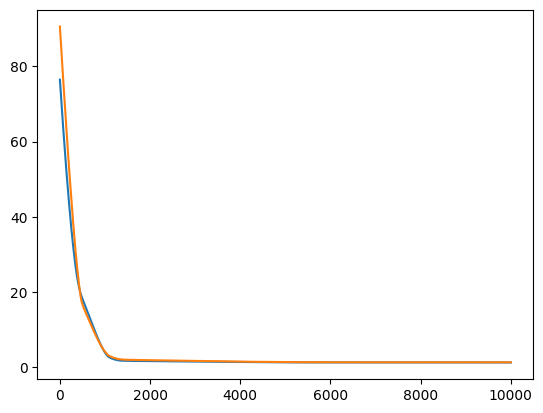

In [270]:
# plot the traing losses and testing losses (0.5 point)
# YOUR CODE HERE
plt.plot(training_losses, label="Training Loss")
plt.plot(testing_losses, label="Testing Loss")
plt.show()

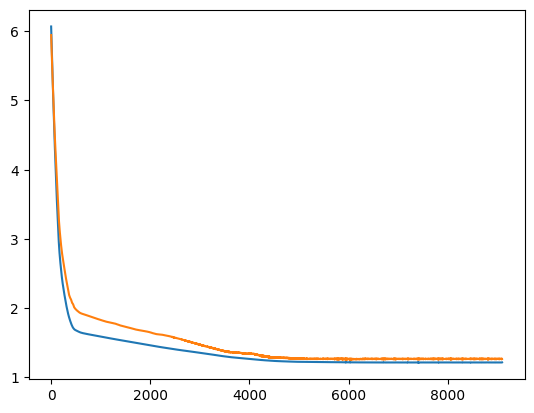

In [272]:
plt.plot(training_losses[901:], label="Training Loss")
plt.plot(testing_losses[901:], label="Testing Loss")
plt.show()

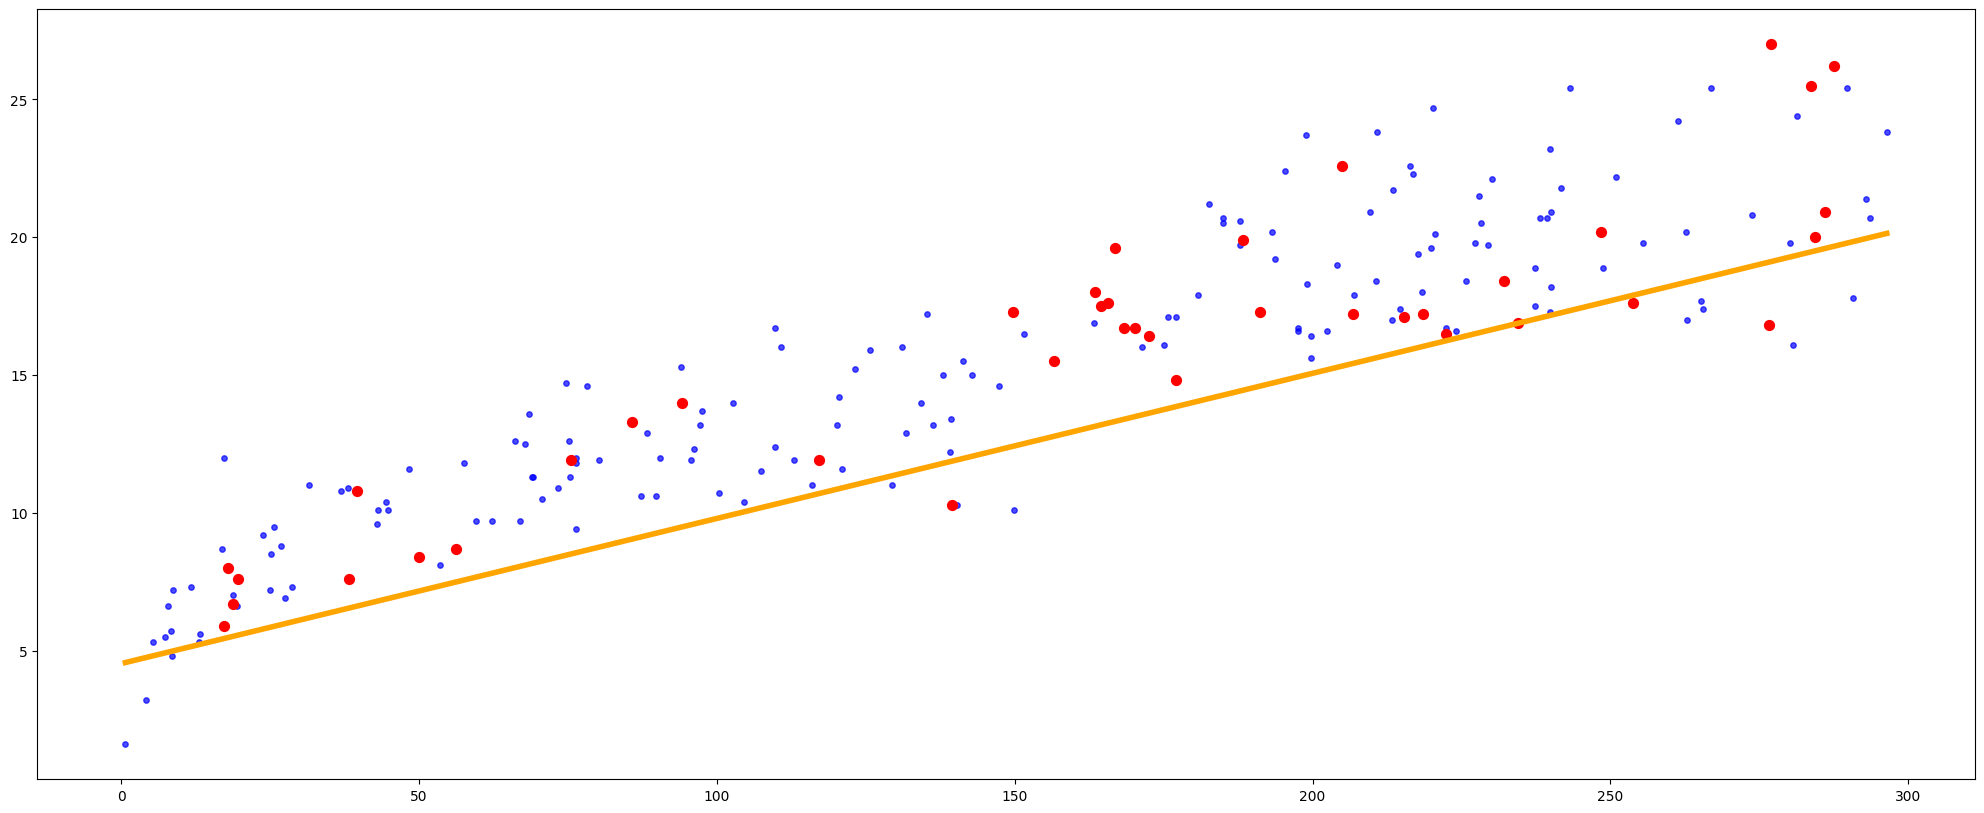

In [273]:
# As our model contains a 3 dimensionsional input, we will only plot the relationship between the first variable 'tv' and the target.
# Again plot the train and test data (from Part1), and add a line where the slope and axis intercept are taken from the model parameters w and b
# (0.5 point)

# YOUR CODE HERE
plt.figure(figsize=(25, 10))
plt.scatter(x_train[:, 0], y_train, label="Training Data", color="blue", s = 15, alpha=0.7)
plt.scatter(x_test[:, 0], y_test, label="Testing Data", color="red", s=50)
#plt.plot(x_train[:, 0], x_train[:, 0]* model.w.data[0]+model.b.data)
#plt.plot(x_test[:, 0], x_test[:, 0]* model.w.data[0]+model.b.data)

tv_range = torch.linspace(min(x_train[:, 0].min(), x_test[:, 0].min()),
                          max(x_train[:, 0].max(), x_test[:, 0].max()), 100)
fitted_line = tv_range * model.w.data[0] + model.b.data

plt.plot(tv_range, fitted_line, label="Fitted Line", color="orange", linewidth=4)
